In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Dense, Flatten
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from random import shuffle
from tqdm import tqdm

In [2]:
TRAIN_DIR = os.getcwd() + '/dataset/training_set/training_set/'
TEST_DIR = os.getcwd() + '/dataset/test_set/test_set/'
image_dimension = 150

In [3]:
train_images_cat = [TRAIN_DIR+'cats/'+i for i in os.listdir(TRAIN_DIR+'cats/')]
train_images_dog = [TRAIN_DIR+'dogs/'+i for i in os.listdir(TRAIN_DIR+'dogs/')]
test_images_cat = [TEST_DIR+'cats/'+i for i in os.listdir(TEST_DIR+'cats/')]
test_images_dog = [TEST_DIR+'dogs/'+i for i in os.listdir(TEST_DIR+'dogs/')]

In [4]:
train_images = train_images_cat + train_images_dog
shuffle(train_images)
test_images = test_images_cat + test_images_dog
shuffle(test_images)

In [5]:
len(train_images), len(test_images)

(8005, 2023)

In [6]:
def find_animal(file_name):
    animal = file_name.split('/')[-1].split('.')[0]
    if(animal == 'cat'): return 0
    elif(animal == 'dog'): return 1

In [7]:
def create_data(images_list):
    data = []
    for file_name in tqdm(images_list):
        animal = find_animal(file_name)
        resized_image = cv2.resize(cv2.imread(file_name), (image_dimension, image_dimension), interpolation=cv2.INTER_AREA)
        data.append([np.array(resized_image), animal])
    shuffle(data)
    return data

In [8]:
training_data = create_data(train_images)

100%|██████████| 8005/8005 [00:23<00:00, 342.80it/s]


In [9]:
testing_data = create_data(test_images)

100%|██████████| 2023/2023 [00:05<00:00, 342.84it/s]


In [10]:
x_train = np.array([i[0] for i in training_data]).reshape(-1, image_dimension, image_dimension, 3)
y_train = np.array([i[1] for i in training_data]).reshape(-1,1)

x_test = np.array([i[0] for i in testing_data]).reshape(-1, image_dimension, image_dimension, 3)
y_test = np.array([i[1] for i in testing_data]).reshape(-1,1)

In [11]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8005, 150, 150, 3), (8005, 1), (2023, 150, 150, 3), (2023, 1))

In [12]:
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [13]:
opt_rms = tf.keras.optimizers.RMSprop(lr=0.0001)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='log_dir/model', histogram_freq=1)

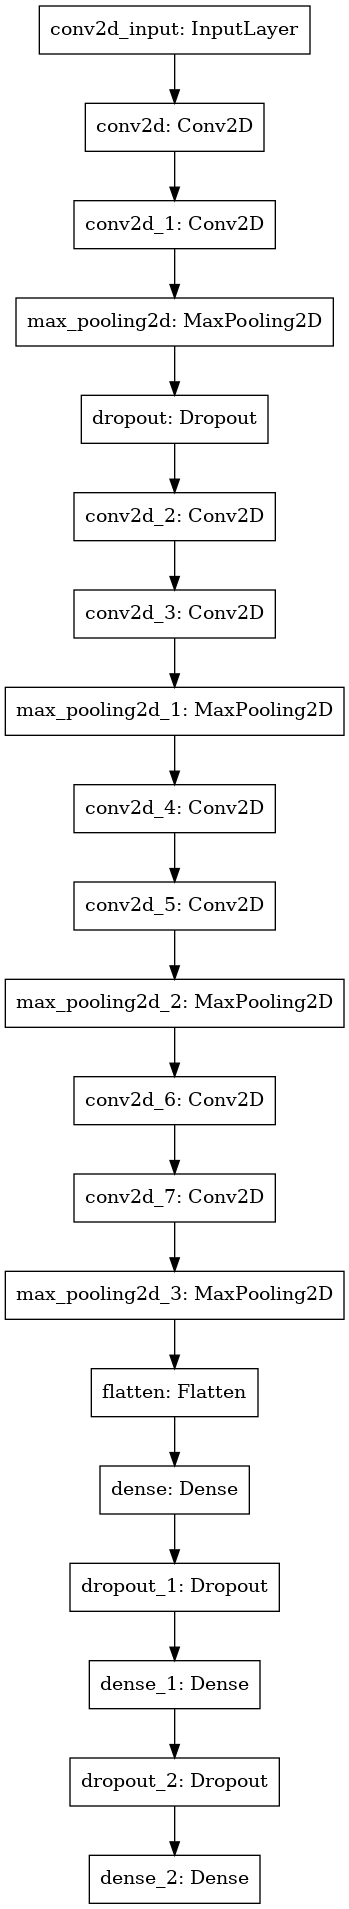

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [15]:
model_info = model.fit(x_train, y_train, batch_size=64, epochs=20, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])

Train on 8005 samples, validate on 2023 samples
Epoch 1/20
8005/8005 [==============================] - 58s 7ms/sample - loss: 0.6933 - accuracy: 0.5084 - val_loss: 0.6927 - val_accuracy: 0.5002
Epoch 2/20
8005/8005 [==============================] - 47s 6ms/sample - loss: 0.6866 - accuracy: 0.5515 - val_loss: 0.8227 - val_accuracy: 0.4998
Epoch 3/20
8005/8005 [==============================] - 42s 5ms/sample - loss: 0.6674 - accuracy: 0.5991 - val_loss: 0.7757 - val_accuracy: 0.5111
Epoch 4/20
8005/8005 [==============================] - 42s 5ms/sample - loss: 0.6593 - accuracy: 0.6140 - val_loss: 0.8150 - val_accuracy: 0.5146
Epoch 5/20
8005/8005 [==============================] - 41s 5ms/sample - loss: 0.6439 - accuracy: 0.6359 - val_loss: 0.6740 - val_accuracy: 0.5719
Epoch 6/20
8005/8005 [==============================] - 42s 5ms/sample - loss: 0.6394 - accuracy: 0.6475 - val_loss: 0.8955 - val_accuracy: 0.5200
Epoch 7/20
8005/8005 [==============================] - 41s 5ms/sample

In [16]:
# for data augmentation

# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# datagen = ImageDataGenerator(rescale=1.0/255.0, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

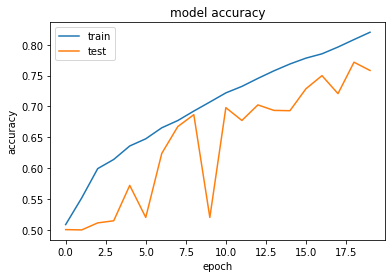

In [17]:
plt.plot(model_info.history['accuracy'])
plt.plot(model_info.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

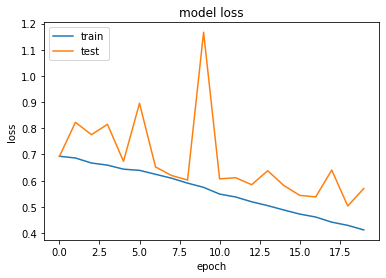

In [18]:
plt.plot(model_info.history['loss'])
plt.plot(model_info.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

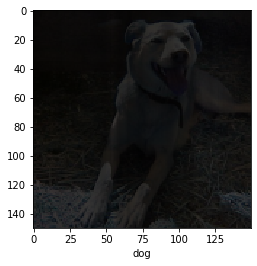

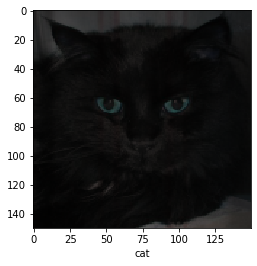

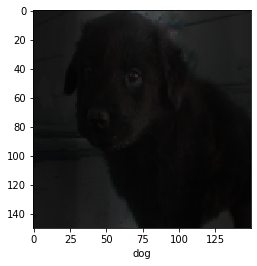

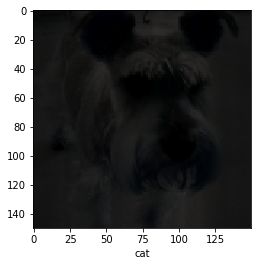

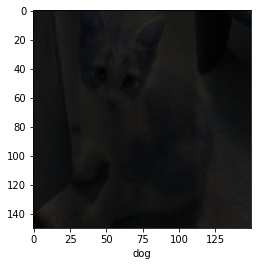

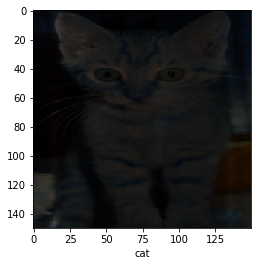

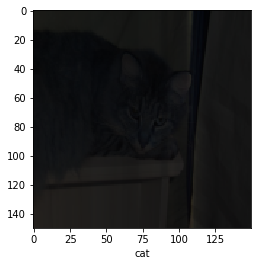

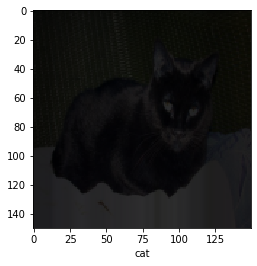

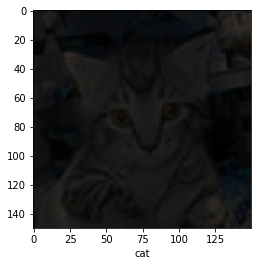

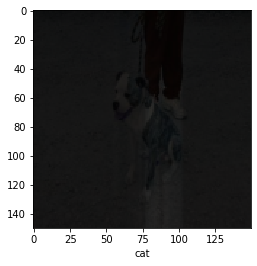

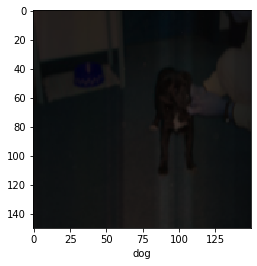

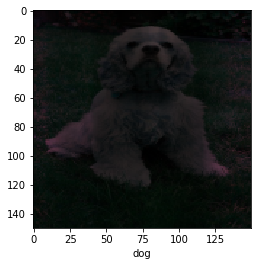

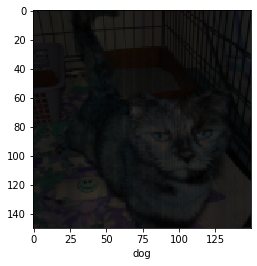

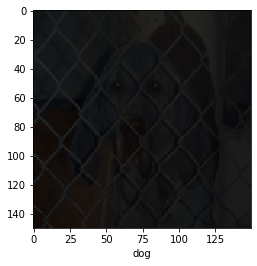

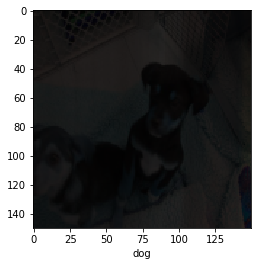

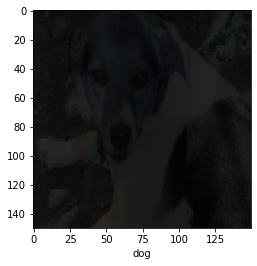

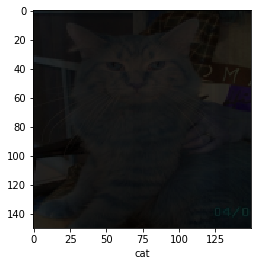

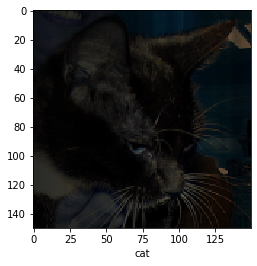

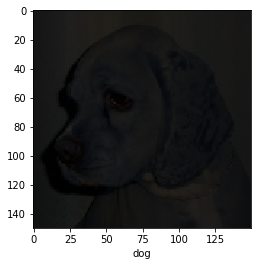

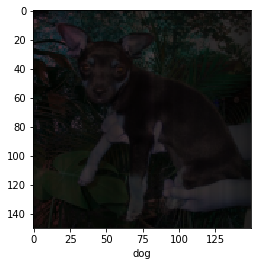

In [19]:
predictions = model.predict([x_test])

data_label = {0:'cat', 1:'dog'}

for x in range(20):
    plt.imshow(x_test[x])
    predicted_label = np.argmax(predictions[x])
    label = data_label[predicted_label]
    plt.xlabel(label)
    plt.show()